In [ ]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
response = llm.invoke("What is the capital of France?")
print(response.content)

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
response = llm.invoke("What is the capital of France?")
print(response.content)

from langchain_core.messages import HumanMessage, SystemMessage
messages = [
    SystemMessage(content="You are a helpful assistant that can answer questions about the weather."),
    HumanMessage(content="What is the weather in Tokyo?")
]

response = llm.invoke(messages)
print(response.content)


The capital of France is Paris.
The capital of France is Paris.
I don't have real-time weather data, but you can easily check the current weather in Tokyo by using a weather website or app. Typically, these platforms provide up-to-date information on temperature, humidity, precipitation, and forecasts. Would you like some tips on how to find this information?
Testing calculator tool



In [25]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def calculator(expression: str) -> str:
    """Calculate mathematical expressions. Allways use this for any math calculations."""
    try:
        result = eval(expression)
        return f"The result of the expression {expression} is {result}"
    except Exception as e:
        return f"Error calcuating {expression}: {e}"
    

search_tool = DuckDuckGoSearchRun()

# Bind tools to the LLM
tools = [calculator, search_tool]
llm_with_tools = llm.bind_tools(tools)

print("Testing calculator tool")
response = llm_with_tools.invoke("What is 25 * 4 + 17?")
print(response.content)

Testing calculator tool



In [26]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1M9wj3z9Mp3aE5FjVIKhnDIr', 'function': {'arguments': '{"expression":"25 * 4 + 17"}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 110, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByeiLIKEPl6pXGWqp0YM1ZyhznZvP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8a5c5f80-4f13-4e76-bcd2-e12dacf80584-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '25 * 4 + 17'}, 'id': 'call_1M9wj3z9Mp3aE5FjVIKhnDIr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 110, 'output_tokens': 20, 'total_tokens': 130, 'inpu

In [27]:
tool_map = {
    "calculator": calculator,
    "duckduckgo_search": DuckDuckGoSearchRun()
}

In [28]:
def handle_tool_calls(response, tool_map):
    """Executes all tool calls in the LLM response using the tool map."""
    if not getattr(response, "tool_calls", None):
        return response
    print(f"Tool calls requested: {len(response.tool_calls)}")
    for tool_call in response.tool_calls:
        tool_name = tool_call["name"]
        args = tool_call["args"]

        print(f"Tool: {tool_name}")
        print(f"Args: {args}")
        
        tool = tool_map.get(tool_name)
        if tool:
            result = tool.invoke(args)
            preview = result[:200] + "..." if isinstance(result, str) and len(result) > 200 else result
            print(f"Tool result: {preview}")

In [29]:
def test_llm_tool(query):
    print(f"Query: {query}")
    response = llm_with_tools.invoke(query)
    print(f"Response: {getattr(response, 'content', response)}")
    handle_tool_calls(response, tool_map)
    print("\n")


test_llm_tool("What is 25 * 4 + 17?")
test_llm_tool("Search for the latest news abount Artificial Intelligence.")

Query: What is 25 * 4 + 17?
Response: 
Tool calls requested: 1
Tool: calculator
Args: {'expression': '25 * 4 + 17'}
Tool result: The result of the expression 25 * 4 + 17 is 117


Query: Search for the latest news abount Artificial Intelligence.
Response: 
Tool calls requested: 1
Tool: duckduckgo_search
Args: {'query': 'latest news about Artificial Intelligence'}


c:\Portfolio\langgraph_exploration\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Tool result: Jun 25, 2025 · Artificial Intelligence News. Everything on AI including futuristic robots with artificial intelligence, computer models of human intelligence and more. A Taruma Baterias oferece bateri...




Structured Output

In [33]:
from pydantic import BaseModel, Field
from typing import List, Optional

class PersonInfo(BaseModel):
    """Information about a person."""
    name: str = Field(description="The full name of the person.")
    age: int = Field(description="The age of the person.")
    occupation: Optional[str] = Field(description="The occupation of the person.")
    skills: List[str] = Field(description="The skills of the person.")

structured_llm = llm.with_structured_output(PersonInfo)


#Test with person info
print("Testing structured output")

person_prompt = """
Extract information about the person:
"John Smith is 30 years old and works as a software engineer. He is skilled in Python, SQL, and machine learning."
"""

response = structured_llm.invoke(person_prompt)
print(response)


print("Name: ", response.name)
print("Age: ", response.age)
print("Occupation: ", response.occupation)
print("Skills: ", ", ".join(response.skills))

Testing structured output
name='John Smith' age=30 occupation='software engineer' skills=['Python', 'SQL', 'machine learning']
Name:  John Smith
Age:  30
Occupation:  software engineer
Skills:  Python, SQL, machine learning


Langgraph Básico

In [34]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [35]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [36]:
def chatbot_node(state: State) -> State:
    """The main chatbot node that processes messages and generates responses."""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

print("Chatbot node function created")

Chatbot node function created


In [37]:
from langgraph.graph import StateGraph, START, END

In [38]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


graph = graph_builder.compile()

In [39]:
img = graph.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)

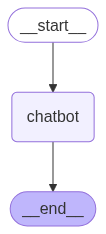

In [40]:
from IPython.display import Image, display
display(Image("graph.png"))

In [41]:
def test_chatbot(message: str):
    """Helper function to test our chatbot."""
    print(f"User: {message}")

    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph.invoke(initial_state)

    ai_response = result["messages"][-1].content
    print(f"AI: {ai_response}")
    return result

test_cases = [
    "Hello! My name is Leonardo?",
    "Do you remember my name?"
]

for test_message in test_cases:
    test_chatbot(test_message)

User: Hello! My name is Leonardo?
AI: Hello, Leonardo! How can I assist you today?
User: Do you remember my name?
AI: I don’t have the ability to remember personal information or previous interactions. However, I'm here to help with any questions or topics you want to discuss! What would you like to talk about?


Adding memory

In [43]:
from langgraph.checkpoint.memory import MemorySaver

In [46]:
memory = MemorySaver()

graph_with_memory = graph_builder.compile(checkpointer=memory)

print("Memory added to chatbot")

def chat_with_memory(message: str, thread_id: str):
    """Chat function with memory"""
    print(f"\n User: {message}")

    config = {"configurable": {"thread_id": thread_id}}

    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph_with_memory.invoke(initial_state, config)

    ai_response = result["messages"][-1].content
    print(f"AI: {ai_response}")
    return result

Memory added to chatbot


In [47]:
print("\n Testing Conversation with Memory:")

chat_with_memory("Hello! My name is Leonardo", thread_id="thead-1")
chat_with_memory("What is my name?", thread_id="thead-1")



 Testing Conversation with Memory:

 User: Hello! My name is Leonardo
AI: Hello, Leonardo! How can I assist you today?

 User: What is my name?
AI: Your name is Leonardo! How can I assist you today?


{'messages': [HumanMessage(content='Hello! My name is Leonardo', additional_kwargs={}, response_metadata={}, id='4a173cb2-5fed-4f7b-8686-fe1305b6774c'),
  AIMessage(content='Hello, Leonardo! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByjxQl5enFzOUrCGpS8KQhC3CCg9K', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7dd02a01-8ac6-4117-bed3-001d7c8e56f6-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),


In [48]:
from typing import TypedDict

class AgentState(TypedDict):
    """State for our two-node agent"""
    messages: list[BaseMessage]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
llm_with_tools = llm.bind_tools(tools)

In [49]:
def chatbot_node(state: AgentState) -> AgentState:
    """The chatbot node decides whether to use tools or provide direct responses"""
    messages = state["messages"]


    system_message = """
    You are a helpful assistant. You have access to web search and calculator tools.

    Use the web_search tool when:
    - Asked about current events, news, or recent information.
    - Need to find specific facts or data.
    - Asked about real-time information (weather, stock prices, etc.)

    Use the calculator tool when:
    - Asked to perform mathematical calculations.
    - Need to solve math problems.

    For general knowledge questions that don't require real-time data, answer directly.
    Be helpful and conversational in your responses.
    """

    all_messages = [
        {"role": "system", "content": system_message}
    ] + messages

    response = llm_with_tools.invoke(all_messages)

    return {"messages": [response]}






In [50]:
from langgraph.prebuilt import ToolNode
from typing import Literal

In [51]:
tools

[StructuredTool(name='calculator', description='Calculate mathematical expressions. Allways use this for any math calculations.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calculator at 0x000002596E8F9440>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))]

In [ ]:
tool_node = ToolNode(tools)
print("Tool node created")

def should_continue(state: AgentState) -> Literal["tool", "end"]:
    """
    Determine whether to continue to tools or end the conversation
    """
    messages = state["messages"]
    last_message = messages[-1]

    





